# Notebook d'inférence : AConvNet

Ce notebook permet d'évaluer des modèles déjà entraînés.

- Visualisation de l'entraînement
- Évaluation sur test set
- Détection d'échantillon hors distribution (tests sur images uploadées par l'utilisateur)

## Importation des librairies

In [1]:
import numpy as np

import json
import glob
import sys
import os

from tqdm import tqdm
import torchvision
import torch

sys.path.append('../src')
from data.MSTAR.paper_AConvNet import preprocess # type: ignore
from data.MSTAR.paper_AConvNet import loader # type: ignore
from data.MSTAR.Felipe import process_mstar_AConvNet # type: ignore
from utils import common # type: ignore
from models.AConvNet.network import AConvNet # type: ignore
from models._base import Model # type: ignore

from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## Choix de l'expérience

In [2]:
experiment_path = "all_AConvNet_1"
experiment_name = "AConvNet-all"
dataset = 'all' # choose between (soc, eoc_1, eoc_2, confuser_rejection)

## Visualisation de l'entraînement

In [3]:
with open(f'./{experiment_path}/history-{experiment_name}.json') as f:
    history = json.load(f)

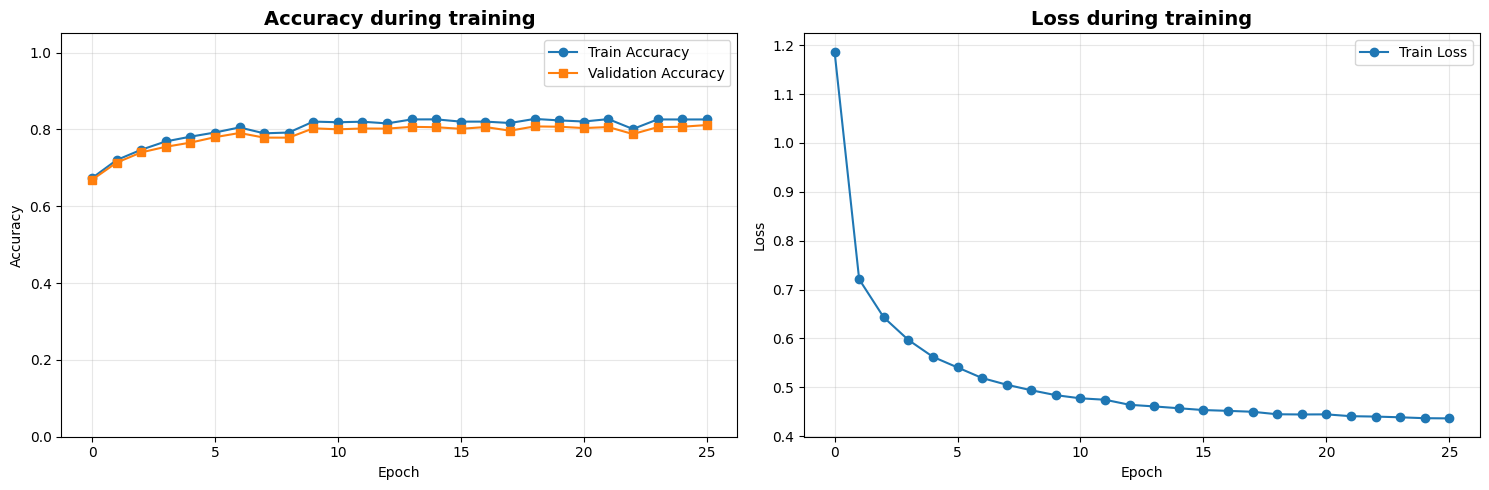

RÉSUMÉ DE L'ENTRAÎNEMENT

 MÉTRIQUES FINALES :
   Train Accuracy      : 82.5859 (8258.59%)
   Validation Accuracy : 81.1298 (8112.98%)
   Train Loss          : 0.436259

 MEILLEURS RÉSULTATS:
   Meilleure Val Accuracy : 81.1298 (8112.98%) à l'epoch 26

 CONVERGENCE:
   Epoch 1 → Epoch finale:
   - Train Accuracy: 67.3209 → 82.5859
   - Val Accuracy  : 66.8710 → 81.1298


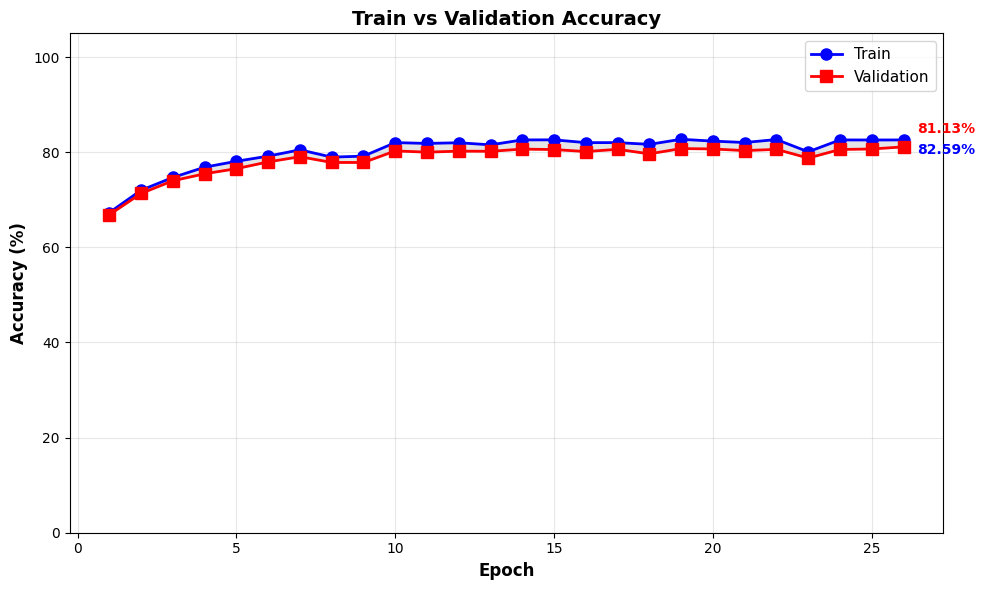

In [4]:
training_loss = history['train_loss']
training_accuracy = history['train_accuracy']
validation_accuracy = history['val_accuracy']

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(np.array(training_accuracy) / 100, label='Train Accuracy', marker='o')
axes[0].plot(np.array(validation_accuracy) / 100, label='Validation Accuracy', marker='s')
axes[0].set_title('Accuracy during training', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim([0, 1.05])

# Loss
axes[1].plot(training_loss, label='Train Loss', marker='o')
axes[1].set_title('Loss during training', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f'./{experiment_path}/training_curves.png')
plt.show()

print("=" * 70)
print("RÉSUMÉ DE L'ENTRAÎNEMENT")
print("=" * 70)

# Métriques finales
final_train_acc = training_accuracy[-1]
final_val_acc = validation_accuracy[-1]
final_train_loss = training_loss[-1]

print(f"\n MÉTRIQUES FINALES :")
print(f"   Train Accuracy      : {final_train_acc:.4f} ({final_train_acc*100:.2f}%)")
print(f"   Validation Accuracy : {final_val_acc:.4f} ({final_val_acc*100:.2f}%)")
print(f"   Train Loss          : {final_train_loss:.6f}")

# Métriques maximales
max_val_acc = max(validation_accuracy)
max_val_acc_epoch = validation_accuracy.index(max_val_acc) + 1

print(f"\n MEILLEURS RÉSULTATS:")
print(f"   Meilleure Val Accuracy : {max_val_acc:.4f} ({max_val_acc*100:.2f}%) à l'epoch {max_val_acc_epoch}")

# Convergence
print(f"\n CONVERGENCE:")
print(f"   Epoch 1 → Epoch finale:")
print(f"   - Train Accuracy: {training_accuracy[0]:.4f} → {final_train_acc:.4f}")
print(f"   - Val Accuracy  : {validation_accuracy[0]:.4f} → {final_val_acc:.4f}")

print("=" * 70)

# Save print output to file
summary_path = os.path.join(f'./{experiment_path}/training_summary.txt')
with open(summary_path, 'w') as f:
    f.write("=" * 70 + "\n")
    f.write("RÉSUMÉ DE L'ENTRAÎNEMENT\n")
    f.write("=" * 70 + "\n")
    f.write(f"\n MÉTRIQUES FINALES :\n")
    f.write(f"   Train Accuracy      : {final_train_acc:.4f} ({final_train_acc*100:.2f}%)\n")
    f.write(f"   Validation Accuracy : {final_val_acc:.4f} ({final_val_acc*100:.2f}%)\n")
    f.write(f"   Train Loss          : {final_train_loss:.6f}\n")
    f.write(f"\n MEILLEURS RÉSULTATS:\n")
    f.write(f"   Meilleure Val Accuracy : {max_val_acc:.4f} ({max_val_acc*100:.2f}%) à l'epoch {max_val_acc_epoch}\n")
    f.write(f"\n CONVERGENCE:\n")
    f.write(f"   Epoch 1 → Epoch finale:\n")
    f.write(f"   - Train Accuracy: {training_accuracy[0]:.4f} → {final_train_acc:.4f}\n")
    f.write(f"   - Val Accuracy  : {validation_accuracy[0]:.4f} → {final_val_acc:.4f}\n")
    f.write("=" * 70 + "\n")

fig, ax = plt.subplots(figsize=(10, 6))

epochs = range(1, len(training_accuracy) + 1)
train_acc = np.array(training_accuracy)
val_acc = np.array(validation_accuracy)

ax.plot(epochs, train_acc, 'b-o', label='Train', linewidth=2, markersize=8)
ax.plot(epochs, val_acc, 'r-s', label='Validation', linewidth=2, markersize=8)
ax.fill_between(epochs, train_acc, val_acc, alpha=0.2, color='gray')

ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
ax.set_title('Train vs Validation Accuracy', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 105])

# Annoter le dernier point
ax.annotate(f'{train_acc[-1]:.2f}%',
            xy=(epochs[-1], train_acc[-1]),
            xytext=(10, -10),
            textcoords='offset points',
            fontweight='bold',
            color='blue')
ax.annotate(f'{val_acc[-1]:.2f}%',
            xy=(epochs[-1], val_acc[-1]),
            xytext=(10, 10),
            textcoords='offset points',
            fontweight='bold',
            color='red')

plt.tight_layout()
plt.show()


## Évaluation sur test set

In [13]:
# load test data and run inference on test data
def load_dataset(path, is_train, name, batch_size, proportion=None):

    _dataset = loader.Dataset(
        path,
        name=name,
        is_train=is_train,
        transform=torchvision.transforms.Compose([
            preprocess.CenterCrop(94),
            torchvision.transforms.Lambda(lambda x: x / 255.0)
        ]),
        proportion=proportion
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_train, num_workers=0
    )
    return data_loader


def evaluate(_m, ds):
    
    num_data = 0
    corrects = 0
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data

        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(_m.device)).sum().item()

    accuracy = 100 * corrects / num_data
    return accuracy

### Choix du meilleur modèle

In [14]:
# print config
with open(f'./{experiment_path}/{experiment_name}.json') as f:
    config = json.load(f)

model_name = config['model_name']
model_str = 'AConvNet'
dataset_path = '../datasets/MSTAR/MSTAR_IMG_JSON'

In [15]:
test_set = load_dataset(dataset_path, False, config['dataset'], 10, config.get('proportion'))

INFO: Proportionning dataset from path: ../datasets/MSTAR/MSTAR_IMG_JSON
INFO: Applying proportion 0.3 to dataset 'all' in mode 'test'
INFO: Class distribution before proportioning: '2S1': 836, 'BRDM2': 561, 'T72': 6102, 'ZSU234': 562, 'BMP2': 1247, 'ZIL131': 548, 'BTR70': 392, 'BTR60': 195, 'D7': 274, 'T62': 273
INFO: Class '2S1': selected 250 out of 836 samples.
INFO: Class 'BRDM2': selected 168 out of 561 samples.
INFO: Class 'T72': selected 1830 out of 6102 samples.
INFO: Class 'ZSU234': selected 168 out of 562 samples.
INFO: Class 'BMP2': selected 374 out of 1247 samples.
INFO: Class 'ZIL131': selected 164 out of 548 samples.
INFO: Class 'BTR70': selected 117 out of 392 samples.
INFO: Class 'BTR60': selected 58 out of 195 samples.
INFO: Class 'D7': selected 82 out of 274 samples.
INFO: Class 'T62': selected 81 out of 273 samples.
load test data set: 100%|██████████| 3292/3292 [00:02<00:00, 1290.59it/s]


In [16]:
net = AConvNet(
        classes=config['num_classes'],
        channels=config['channels'],
        dropout_rate=config['dropout_rate']
    )

m = Model(
    net=net,
    lr=config['lr'], 
    lr_step=config['lr_step'],
    lr_decay=config['lr_decay'],
    weight_decay=config['weight_decay'],
    criterion=torch.nn.CrossEntropyLoss(),
)


Device used: cpu


In [9]:
# model_history = glob.glob(os.path.join(common.project_root, f'experiments/{model_str}/model/{model_name}/*.pth'))
model_history = glob.glob(os.path.join(common.project_root, f'notebooks/{experiment_path}/*.pth'))
model_history = sorted(model_history, key=os.path.basename)

best = {
    'epoch': 0,
    'accuracy': 0,
    'path': ''
}

for i, model_path in enumerate(model_history):
    m.load(model_path)
    accuracy = evaluate(m, test_set)
    if accuracy > best['accuracy']:
        best['epoch'] = i
        best['accuracy'] = accuracy
        best['path'] = model_path
        print(f'Best accuracy at epoch={i} with {accuracy:.2f}%')
    
best_epoch = best['epoch']
best_accuracy = best['accuracy']
best_path = best['path']

print(f'Final model is epoch={best_epoch} with accurayc={best_accuracy:.2f}%')
# Manually choose if too long
# best_path = '/home/mqtho/ATR-Code/notebooks/all_AConvNet_1/model-026.pth'
print(f'Path={best_path}')

Best accuracy at epoch=0 with 6.93%
Best accuracy at epoch=1 with 14.79%
Best accuracy at epoch=2 with 29.71%
Best accuracy at epoch=4 with 49.97%


KeyboardInterrupt: 

In [ ]:
best_path = '/home/mqtho/ATR-Code/notebooks/all_AConvNet_1/model-026.pth'
m.load(best_path)

### Métriques et Matrice de confusion

In [18]:
def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        
        _pred += predictions.cpu().tolist()
        _gt += labels.cpu().tolist()
        
    conf_mat = metrics.confusion_matrix(_gt, _pred)

    classification_report = metrics.classification_report(_gt, _pred)

    print(classification_report)

    clf_report_path = os.path.join(f'./{experiment_path}/classification_report.txt')
    with open(clf_report_path, 'w') as f:
        f.write(classification_report)
    
    return conf_mat

              precision    recall  f1-score   support

           0       0.71      0.65      0.68       482
           1       0.09      0.04      0.06       207
           2       0.03      0.17      0.05       220
           3       0.77      0.22      0.34      1863
           4       0.43      0.27      0.33       145
           5       0.62      0.98      0.75        82
           6       0.20      0.85      0.32        81
           7       0.12      0.30      0.17        54
           8       0.47      0.51      0.49        83
           9       0.86      0.65      0.74        75

    accuracy                           0.32      3292
   macro avg       0.43      0.46      0.39      3292
weighted avg       0.62      0.32      0.37      3292



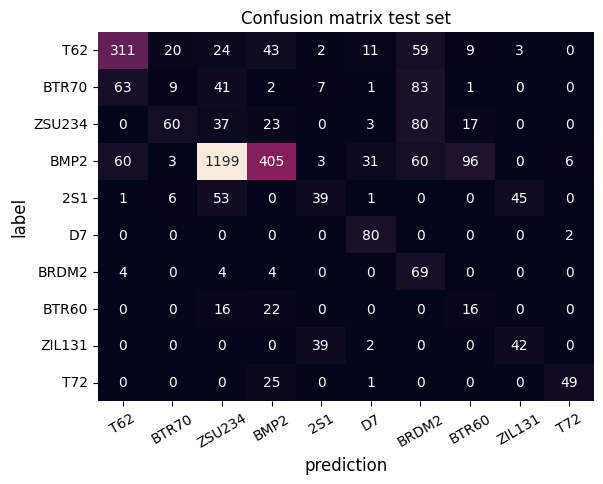

In [19]:
# Confusion matrix
_conf_mat = confusion_matrix(m, test_set)

sns.reset_defaults()
ax = sns.heatmap(_conf_mat, annot=True, fmt='d', cbar=False)

target_attr = f'target_name_{dataset}'
target_names = getattr(process_mstar_AConvNet, target_attr)
ax.set_yticklabels(target_names, rotation=0)
ax.set_xticklabels(target_names, rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)
plt.title('Confusion matrix test set')

plt.savefig(f'./{experiment_path}/confusion_matrix_test.png')

plt.show()

## Definition de méthodes de OOD detection

In [20]:
import scipy.stats
def detect_ood(logits, probabilities, confidence_threshold=0.75, energy_threshold=-25.0):
    """
    This functions implements several OOD detection methods (probability-based, entropy-based, energy-based).
    These are methods used to detect OOD after training, when no 'unknown' class was added in training.
    The thresholds have to be calibrated to the model.
    Returns: (is_ood, reason, metrics)
    """
    probs_np = probabilities[0].cpu().numpy()
    
    # Method 1: Max probability check
    max_prob = probs_np.max()
    
    # Method 2: Energy score (lower = more in-distribution)
    energy = -torch.logsumexp(logits, dim=1).item()
    
    # Method 3: Entropy (higher = more uncertain)
    entropy = scipy.stats.entropy(probs_np)
    n_classes = len(probs_np)
    max_entropy = np.log(n_classes)
    normalized_entropy = entropy / max_entropy
    
    # # Method 4: Check if distribution is too uniform
    # prob_std = np.std(probs_np)
    # uniform_std = 1.0 / np.sqrt(n_classes)
    
    # Decision logic
    reasons = []
    is_ood = False
    
    if max_prob < confidence_threshold:
        is_ood = True
        reasons.append(f"Low confidence ({max_prob:.2%} < {confidence_threshold:.2%})")
    
    if energy > energy_threshold:
        is_ood = True
        reasons.append(f"High energy score ({energy:.2f} > {energy_threshold:.2f})")
    
    if normalized_entropy > 0.8:
        is_ood = True
        reasons.append(f"High entropy ({normalized_entropy:.2f} > 0.8)")
    
    # if prob_std < uniform_std * 1.3:
    #     is_ood = True
    #     reasons.append(f"Too uniform distribution (std={prob_std:.4f})")
    
    metrics = {
        'max_prob': max_prob,
        'energy': energy,
        'entropy': entropy,
        'normalized_entropy': normalized_entropy,
        # 'prob_std': prob_std
    }
    
    return is_ood, reasons, metrics


# Function to calibrate confidence and energy threshold on train/validation set.
def calibrate_ood_thresholds(model, train_loader, device, target_fpr=0.05):
    """
    Calibrate OOD detection thresholds on validation set (in-distribution data).
    
    Args:
        model: trained model
        train_loader: DataLoader with in-distribution data
        device: torch device
        target_fpr: target false positive rate (e.g., 0.05 = 5% of ID samples marked as OOD)
    
    Returns:
        dict with calibrated thresholds
    """
    
    all_max_probs = []
    all_energies = []
    all_normalized_entropies = []
    
    with torch.no_grad():
        for images, _, _ in train_loader:
            logits = model.inference(images)
            probabilities = torch.nn.functional.softmax(logits, dim=1)
            
            for i in range(logits.shape[0]):
                probs_np = probabilities[i].cpu().numpy()
                
                # Collect metrics
                max_prob = probs_np.max()
                energy = -torch.logsumexp(logits[i:i+1], dim=1).item()
                entropy = scipy.stats.entropy(probs_np)
                n_classes = len(probs_np)
                normalized_entropy = entropy / np.log(n_classes)
                
                all_max_probs.append(max_prob)
                all_energies.append(energy)
                all_normalized_entropies.append(normalized_entropy)
    
    all_max_probs = np.array(all_max_probs)
    all_energies = np.array(all_energies)
    all_normalized_entropies = np.array(all_normalized_entropies)
    
    # Calculate thresholds based on percentiles
    # Lower percentile for max_prob (we want high confidence for ID)
    confidence_threshold = np.percentile(all_max_probs, target_fpr * 100)
    
    # Upper percentile for energy (lower energy = more ID)
    energy_threshold = np.percentile(all_energies, (1 - target_fpr) * 100)
    
    # Upper percentile for entropy (lower entropy = more certain)
    entropy_threshold = np.percentile(all_normalized_entropies, (1 - target_fpr) * 100)
    
    thresholds = {
        'confidence_threshold': confidence_threshold,
        'energy_threshold': energy_threshold,
        'entropy_threshold': entropy_threshold,
        'statistics': {
            'max_prob': {
                'mean': all_max_probs.mean(),
                'std': all_max_probs.std(),
                'min': all_max_probs.min(),
                'max': all_max_probs.max(),
                'percentiles': {
                    '1%': np.percentile(all_max_probs, 1),
                    '5%': np.percentile(all_max_probs, 5),
                    '10%': np.percentile(all_max_probs, 10),
                }
            },
            'energy': {
                'mean': all_energies.mean(),
                'std': all_energies.std(),
                'min': all_energies.min(),
                'max': all_energies.max(),
                'percentiles': {
                    '90%': np.percentile(all_energies, 90),
                    '95%': np.percentile(all_energies, 95),
                    '99%': np.percentile(all_energies, 99),
                }
            },
            'entropy': {
                'mean': all_normalized_entropies.mean(),
                'std': all_normalized_entropies.std(),
                'min': all_normalized_entropies.min(),
                'max': all_normalized_entropies.max(),
                'percentiles': {
                    '90%': np.percentile(all_normalized_entropies, 90),
                    '95%': np.percentile(all_normalized_entropies, 95),
                    '99%': np.percentile(all_normalized_entropies, 99),
                }
            }
        }
    }
    
    return thresholds

In [ ]:
train_set = load_dataset(dataset_path, True, config['dataset'], 10)

thresholds = calibrate_ood_thresholds(m, train_set, m.device)

print(thresholds)

CONFIDENCE_THRESHOLD = thresholds['confidence_threshold'] # Adjust based on your validation

CONFIDENCE_THRESHOLD = 0.8
ENERGY_THRESHOLD = thresholds['energy_threshold'] # Adjust based on your validation

load train data set:   0%|          | 0/2747 [00:00<?, ?it/s]

load train data set: 100%|██████████| 2747/2747 [00:00<00:00, 3133.66it/s]


{'confidence_threshold': np.float32(0.9999999), 'energy_threshold': np.float64(-27.17360076904298), 'entropy_threshold': np.float64(5.635901843106501e-07), 'statistics': {'max_prob': {'mean': np.float32(0.99945873), 'std': np.float32(0.011159108), 'min': np.float32(0.5851892), 'max': np.float32(1.0), 'percentiles': {'1%': np.float32(0.99971473), '5%': np.float32(0.9999999), '10%': np.float32(1.0)}}, 'energy': {'mean': np.float64(-72.19276837188198), 'std': np.float64(34.342813319828835), 'min': np.float64(-295.32196044921875), 'max': np.float64(-7.372027397155762), 'percentiles': {'90%': np.float64(-33.700653076171854), '95%': np.float64(-27.17360076904298), '99%': np.float64(-17.178031959533705)}}, 'entropy': {'mean': np.float64(0.000632920813937627), 'std': np.float64(0.010852365495062914), 'min': np.float64(0.0), 'max': np.float64(0.3046740160237522), 'percentiles': {'90%': np.float64(1.1063521693360583e-09), '95%': np.float64(5.635901843106501e-07), '99%': np.float64(0.001172405320

### Prédictions sur image uploadée par utilisateur

In [ ]:
## Test on one image
import io
import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output
import cv2

# input : an image uploaded by the user (if possible widget in jupyter notebook)
# Define the Widget Interface
upload_btn = widgets.FileUpload(
    accept='.jpg,.png,.jpeg,.tif',  # Acceptable formats
    multiple=False,
    description='Upload SAR Image'
)
output_area = widgets.Output()


def on_upload_change(change):
    # This function triggers automatically when an image is uploaded
    if not change['new']:
        return
    
    with output_area:
        clear_output(wait=True)
        
        # Decode the uploaded image
        # 'change['new']' contains the uploaded file metadata and content
        uploaded_file = change['new'][0] 
        content = uploaded_file['content']
        
        nparr = np.frombuffer(content, np.uint8)
        image = cv2.imdecode(nparr, cv2.IMREAD_GRAYSCALE)

        # # Display the Image
        # fig, ax = plt.subplots(figsize=(4, 4))
        # ax.imshow(image, cmap='gray')
        # ax.set_title("Uploaded Sample")
        # ax.axis('off')
        # plt.show()
        # plt.close(fig)

        if len(image.shape) < 3:
            image = np.expand_dims(image, axis=0) # add channel dim
        image_tensor = torch.tensor(image, dtype=torch.float32)
        
        
        # C. Preprocess for the Model (IMPORTANT !! It has to be the same as the preprocessing used for inference above)
        # Convert PIL -> Tensor and add Batch Dimension (1, C, H, W)
        try:
            transform = torchvision.transforms.Compose([
                preprocess.CenterCrop(94)
            ])
            input_tensor = transform(image_tensor)
            input_batch = input_tensor.unsqueeze(0) 
            
            # Send to Device (GPU/CPU)
            device = m.device
            input_batch = input_batch.to(device)
            
            # D. Inference
            predictions = m.inference(input_batch)
            
            # E. Format and Display Results
            if isinstance(predictions, torch.Tensor):
                probabilities = torch.nn.functional.softmax(predictions, dim=1)
                # top_prob, top_class = torch.max(probabilities, 1)

                # print("\n--- Inference Results ---")

                # predicted_class = target_names[top_class.item()] if top_prob.item() > 0.3 else "Rejet"
                # print(f"Predicted Class: {predicted_class}")
                # print(f"Confidence:      {top_prob.item()*100:.4f}%")
                
                # # Show all probabilities
                # print("\nFull breakdown:")
                # for i, prob in enumerate(probabilities[0]):
                #     print(f"  {target_names[i]:<10}: {prob.item()*100:.2f}%")

                # OOD Detection
                is_ood, reasons, metrics = detect_ood(
                    predictions, 
                    probabilities,
                    confidence_threshold=CONFIDENCE_THRESHOLD,
                    energy_threshold=ENERGY_THRESHOLD 
                )

                # Display image and probabilities
                fig, axes = plt.subplots(1, 2, figsize=(12, 4))
                
                # Show image
                axes[0].imshow(input_tensor.squeeze().cpu().numpy(), cmap='gray')
                axes[0].set_title(f"Uploaded: sample")
                axes[0].axis('off')
                
                # Show probability distribution
                probs_np = probabilities[0].cpu().numpy()
                axes[1].bar(range(len(target_names)), probs_np)
                axes[1].set_xlabel('Class')
                axes[1].set_ylabel('Probability')
                axes[1].set_title('Prediction Probabilities')
                axes[1].set_xticks(range(len(target_names)))
                axes[1].set_xticklabels(target_names, rotation=45, ha='right')
                axes[1].axhline(y=0.75, color='r', linestyle='--', label='Threshold', alpha=0.7)
                axes[1].legend()
                axes[1].grid(axis='y', alpha=0.3)
                
                plt.tight_layout()
                plt.show()
                plt.close(fig)
                
                # Print results
                print("\n" + "="*60)
                
                if is_ood:
                    print("⚠️  OUT-OF-DISTRIBUTION DETECTION")
                    print("="*60)
                    print("This image is likely NOT from any known class.")
                    print("\nReasons:")
                    for reason in reasons:
                        print(f"  • {reason}")
                    print("\n→ Prediction: REJECTED")
                    
                else:
                    print("✓ IN-DISTRIBUTION PREDICTION")
                    print("="*60)
                    top_prob, top_class = torch.max(probabilities, 1)
                    predicted_class = target_names[top_class.item()]
                    print(f"Predicted Class: {predicted_class}")
                    print(f"Confidence:      {top_prob.item()*100:.2f}%")
                
                print("\n" + "-"*60)
                print("Uncertainty Metrics:")
                print(f"  Max Probability:     {metrics['max_prob']:.4f}")
                print(f"  Energy Score:        {metrics['energy']:.4f}")
                print(f"  Normalized Entropy:  {metrics['normalized_entropy']:.4f}")
                # print(f"  Prob Std Dev:        {metrics['prob_std']:.4f}")
                
                # print("\n" + "-"*60)
                # print("Full Class Breakdown:")
                # for i, prob in enumerate(probabilities[0]):
                #     status = "✓" if i == top_class.item() and not is_ood else " "
                #     print(f"  {status} {target_names[i]:<15}: {prob.item()*100:6.2f}%")
                # print("="*60)
                
                    
        except Exception as e:
            print(f"\n[Error] Inference failed: {e}")
            print("Check your tensor shapes or preprocessing transforms.")

# 3. Link the event handler and display
upload_btn.observe(on_upload_change, names='value')
display(widgets.VBox([upload_btn, output_area]))